# Process CESM2 data for S2S analysis

In [1]:
import os
import sys
import time
import imp
import glob

import os.path
from   os import path
import subprocess

import numpy as np
import pandas as pd
import xarray as xr
from   tqdm import trange
from   icecream import ic

from scipy.ndimage import gaussian_filter as gaussian_filter

# import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
__author__ = "Elizabeth A. Barnes and Randal J Barnes"
__version__ = "23 November 2021"

In [3]:
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
dpiFig = 300.

## Print the detailed system info

In [4]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")

python version = 3.9.12 (main, Apr  5 2022, 01:53:17) 
[Clang 12.0.0 ]
numpy version = 1.21.5


## Data directories

In [5]:
save_dir = './'

## Create data

A map with four regions of variability for some unspecified field

Text(0.5, 1.0, 'Four regions')

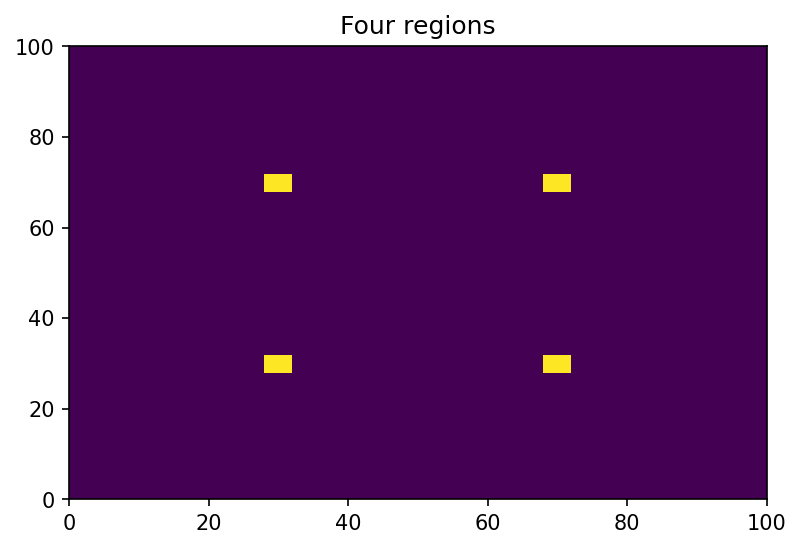

In [6]:
# Choose a seed for consistent results
np.random.seed(42)

# Defining four regions
rdata = np.zeros((9000,100,100))
rdata[:,28:32,28:32] = 1
rdata[:,68:72,28:32] = 2
rdata[:,28:32,68:72] = 3
rdata[:,68:72,68:72] = 4

plt.pcolor(rdata[0], vmin = .25, vmax = .75)
plt.title("Four regions")

In [7]:
onoff = np.random.choice([0.,1.,-1.],size=(40_000,4))
labels = 2*np.ones((onoff.shape[0],1))

# negative on top edge
i = np.where((onoff[:,2]<0) & (onoff[:,1]<0))[0]
labels[i] = 0
neg_len = len(i)

# positive on left hand edge
i = np.where((onoff[:,0]>0) & (onoff[:,1]>0))[0]
labels[i] = 1
pos_len = len(i)

# the rest
rest_len = np.shape(onoff)[0]-pos_len-neg_len

print(pos_len)
print(neg_len)
print(rest_len)

# # make equal number in each class
# import sklearn

# onoff = sklearn.utils.resample(onoff, replace=False, n_samples=12_000, random_state=None, stratify=labels)


4460
4360
31180


In [8]:
n = 3_000
onoff_new = np.zeros((1,4))
labels_new = []

# negative on top edge
i = np.where(labels==0)[0]
k = np.random.choice(i,n)
onoff_new = np.append(onoff_new, onoff[k],axis=0)
labels_new = np.append(labels_new, labels[k])

# positive on left hand edge
i = np.where(labels==1)[0]
k = np.random.choice(i,n)
onoff_new = np.append(onoff_new, onoff[k],axis=0)
labels_new = np.append(labels_new, labels[k])

# everything else
i = np.where(labels==2)[0]
k = np.random.choice(i,n)
onoff_new = np.append(onoff_new, onoff[k],axis=0)
labels_new = np.append(labels_new, labels[k])

onoff_new = onoff_new[1:,:]
labels_new = np.asarray(labels_new)

In [9]:
ic(np.shape(onoff_new))
ic(np.shape(labels_new))

ic| np.shape(onoff_new): (9000, 4)
ic| np.shape(labels_new): (9000,)


(9000,)

In [10]:
# First we are going to make a 100 x 100 grid that will be filled with random data, 10000 times
data = np.random.randn(9000, 100, 100)
rvals = np.random.uniform(2,15,size=(data.shape[0],4))
rvals = rvals*onoff_new
        
# And add these random values to each square
for i in [0,1,2,3]:
    data += (rvals[:,i] * (rdata == i+1).T).T

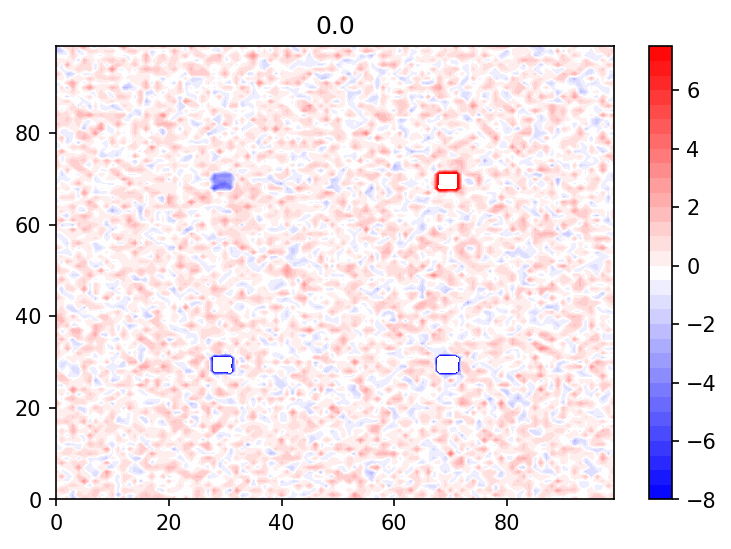

In [11]:
index = 1004
plt.contourf(data[index], levels = np.arange(-8, 8, .5), cmap='bwr')
plt.title(labels_new[index])
plt.colorbar()

In [12]:
# And add a Gaussian filter to make things look 'atmosphere-y'
newdata = data.copy()

for i in range(data.shape[0]):
    newdata[i] = gaussian_filter(data[i], 7)

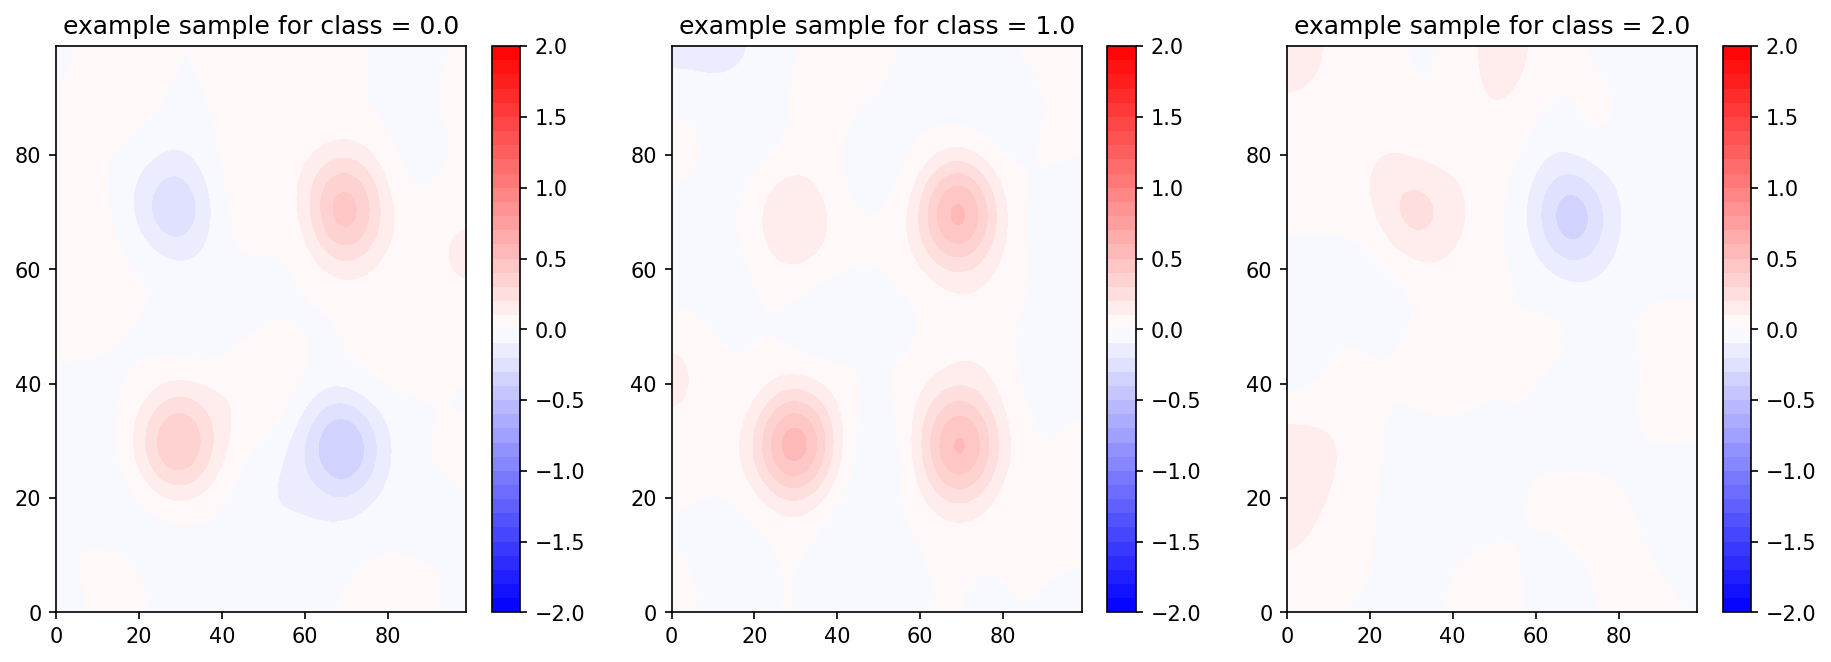

In [13]:
plt.figure(figsize=(15,5))
for l in (0,1,2):
    plt.subplot(1,3,l+1)
    index = np.where(labels_new==l)[0][10]
    plt.contourf(newdata[index], levels = np.arange(-2., 2.1, .1), cmap='bwr')
    plt.title('example sample for class = ' + str(labels_new[index]))
    plt.colorbar()
plt.show()

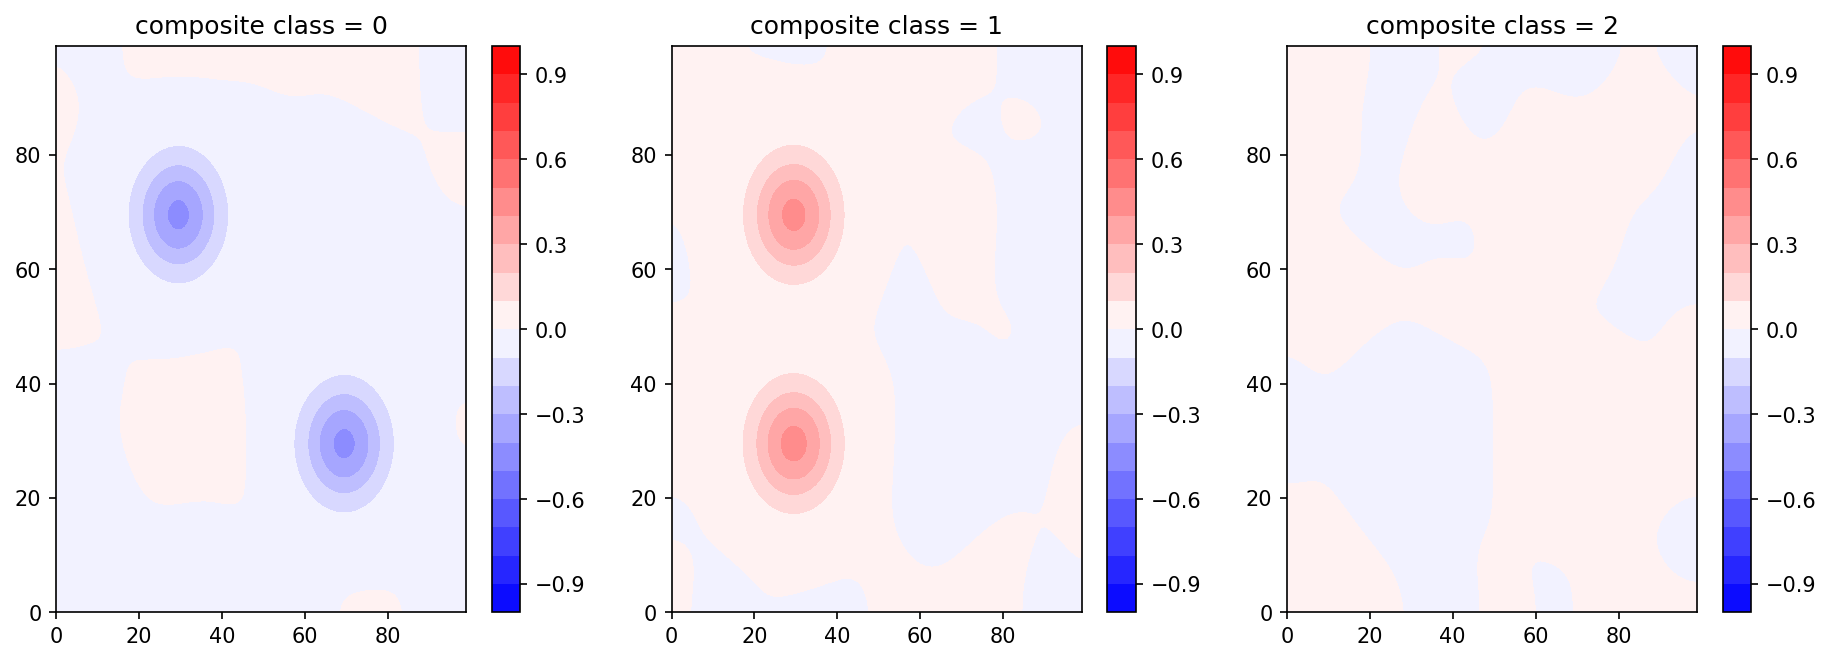

In [14]:
plt.figure(figsize=(15,5))
for l in (0,1,2):
    plt.subplot(1,3,l+1)
    index = np.where(labels_new==l)[0]
    plot_map = np.mean(newdata[index],axis=0)
    plt.contourf(plot_map, levels = np.arange(-1., 1.1, .1), cmap='bwr')
    plt.title('composite class = ' + str(l))
    plt.colorbar()
plt.show()

In [15]:
ic(data[index,10,10])
ic(newdata[index,10,10])

ic| data[index,10,10]: array([-0.15085622, -0.18524347, -0.73088186, ..., -1.24519658,
                               0.96484954,  0.36232376])
ic| newdata[index,10,10]: array([ 0.05294375, -0.01997278, -0.03614621, ..., -0.03556061,
                                  0.01160614,  0.09003961])


array([ 0.05294375, -0.01997278, -0.03614621, ..., -0.03556061,
        0.01160614,  0.09003961])

## Save the data

In [16]:
from scipy.io import savemat

data_save   = np.asarray(newdata)[:,:,:,np.newaxis]
labels_save = np.asarray(labels_new,dtype='int32')
savemat(save_dir + 'data_quadrants.mat', {'data':data_save, 'labels':labels_save})

: 